# Sugestão de cidade do Estado do Rio Grande do Sul pelo Índice de Criminalidade
### Para o trabalho final da disciplina de Sistemas Operacionais foi escolhido os bancos de dados Índice de Criminalidade (RS, 2023) e Estimativas Populacionais (RS, 2022). Os dados são reais e estão disponíveis no portal Dados Abertos RS do Estado do Rio Grande do Sul.
###  Este trabalho tem como objetivo análisar a similaridade, usando a métrica de distância eucliana, das cidades e os ratigns dos dos usuários e, então responder: "Quais as cidades o algoritmo sugere?".
Indíce de Criminalidade no RS: [https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023](https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023)

Estimativas Populacionais no RS: [https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26](https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26)

## Pré-processamento
Houve a necessidade de realizar o pré-processamento dos dados, pois foram disponibilizados em planilhas Excel com formatações diversas.

In [1127]:
import pandas as pd

Abertura dos arquivos de criminalidade por cidade em cada mês.

In [1128]:
# Lendo os arquivos csv e concatenando em um único dataframe
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

dfs = []

for mes in meses:
        arquivo = pd.read_csv(f'data\\tocsv\\{mes}.csv', delimiter=';')
        dfs.append(arquivo)

df = pd.concat(dfs, ignore_index=True)

df_criminal = df.groupby(['municipios', 'ibge']).sum().reset_index()


df.to_csv('data\\tocsv\\total.csv', sep=';', index=False)

df_criminal.head()


,municipios,ibge,homicidio_doloso,total_vitimas_homicidio_doloso,latrocinio,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,total_vitimas_crimes_violentos
0,acegua,4300034,0,0,0,20,8,0,3,0,27,4,3,0,0,0,0
1,agua santa,4300059,1,1,0,20,3,4,1,0,13,2,0,0,0,0,2
2,agudo,4300109,1,1,0,102,2,2,3,1,51,3,7,10,0,0,1
3,ajuricaba,4300208,0,0,0,26,1,0,1,0,28,2,3,0,0,0,0
4,alecrim,4300307,1,1,0,36,10,0,2,0,17,10,0,4,0,0,1


Abertura do arquivo de quantidade de população por cidade em cada ano.

In [1129]:
# Lendo o arquivo de população
df_pop = pd.read_csv('data\\tocsv\\populacao.csv', delimiter=';')

# Substituindo os valores de '.' e '-' por 0 e convertendo para inteiro
for coluna in df_pop.columns[4:]:
    df_pop[coluna] = df_pop[coluna].str.replace('.', '').str.replace('-', '0').astype(int)

df_pop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   municipios  497 non-null    object 
 1   ibge        497 non-null    int64  
 2   latitude    497 non-null    float64
 3   longitude   497 non-null    float64
 4   2010        497 non-null    int32  
 5   2011        497 non-null    int32  
 6   2012        497 non-null    int32  
 7   2013        497 non-null    int32  
 8   2014        497 non-null    int32  
 9   2015        497 non-null    int32  
 10  2016        497 non-null    int32  
 11  2017        497 non-null    int32  
 12  2018        497 non-null    int32  
 13  2019        497 non-null    int32  
 14  2020        497 non-null    int32  
 15  2021        497 non-null    int32  
dtypes: float64(2), int32(12), int64(1), object(1)
memory usage: 39.0+ KB


União dos dois banco de dados.

In [1130]:
# O merge é feito com base na coluna ibge como forma de chave estrangeira com o método inner
df_merged = pd.merge(df_criminal, df_pop, how = 'inner', on = 'ibge').drop(columns=['municipios_y'])
df_merged.rename(columns={'municipios_x': 'municipios'}, inplace=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   municipios                      497 non-null    object 
 1   ibge                            497 non-null    int64  
 2   homicidio_doloso                497 non-null    int64  
 3   total_vitimas_homicidio_doloso  497 non-null    int64  
 4   latrocinio                      497 non-null    int64  
 5   furtos                          497 non-null    int64  
 6   abigeato                        497 non-null    int64  
 7   furto_veiculo                   497 non-null    int64  
 8   roubos                          497 non-null    int64  
 9   roubo_veiculo                   497 non-null    int64  
 10  estelionato                     497 non-null    int64  
 11  delitos_armas_municoes          497 non-null    int64  
 12  entorpecente_posse              497 

Normalização dos dados.

In [1131]:
from sklearn.preprocessing import StandardScaler

In [1132]:
# Lista das colunas extras que não são necessárias
colunas_extras = df_merged.columns[16:30]

# Removendo as colunas extras
df = df_merged.drop(colunas_extras, axis=1)

df.set_index('municipios', inplace=True)

# Salvando o dataframe em um arquivo csv
df.to_csv('data\\tocsv\\dados_pop_criminalidade.csv', sep=';', index=False)

df.head()



,ibge,homicidio_doloso,total_vitimas_homicidio_doloso,latrocinio,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,2021
municipios,,,,,,,,,,,,,,,,
acegua,4300034,0,0,0,20,8,0,3,0,27,4,3,0,0,0,4505
agua santa,4300059,1,1,0,20,3,4,1,0,13,2,0,0,0,0,4256
agudo,4300109,1,1,0,102,2,2,3,1,51,3,7,10,0,0,16612
ajuricaba,4300208,0,0,0,26,1,0,1,0,28,2,3,0,0,0,7447
alecrim,4300307,1,1,0,36,10,0,2,0,17,10,0,4,0,0,6403


In [1133]:
# Removendo as colunas de taxa total pois são redundantes
df.drop(['total_vitimas_homicidio_doloso'], axis='columns', inplace=True)
df.drop(['latrocinio'], axis='columns', inplace=True)

# Selecionando somente as colunas do tipo float
df.drop(['ibge'], axis='columns', inplace=True)

df.rename(columns={'2021': 'populacao'}, inplace=True)

In [1134]:
# Normalizando os dados média 0 e desvio padrão 1
scaler = StandardScaler(with_std=True, with_mean=True)
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

data_scaled.head()

,homicidio_doloso,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,populacao
municipios,,,,,,,,,,,,,
acegua,-0.240983,-0.165023,-0.016371,-0.189482,-0.091215,-0.108250,-0.174139,-0.221637,-0.264673,-0.205293,-0.202622,-0.193052,-0.234986
agua santa,-0.163812,-0.165023,-0.347109,-0.145451,-0.094148,-0.108250,-0.190466,-0.270616,-0.287715,-0.205293,-0.202622,-0.193052,-0.238138
agudo,-0.163812,-0.106419,-0.413257,-0.167466,-0.091215,-0.093268,-0.146148,-0.246127,-0.233949,-0.141324,-0.202622,-0.193052,-0.081756
ajuricaba,-0.240983,-0.160734,-0.479404,-0.189482,-0.094148,-0.108250,-0.172972,-0.270616,-0.264673,-0.205293,-0.202622,-0.193052,-0.197751
alecrim,-0.163812,-0.153588,0.115925,-0.189482,-0.092681,-0.108250,-0.185801,-0.074700,-0.287715,-0.179705,-0.202622,-0.193052,-0.210964


## PCA - Redução de Dimensionalidade
### O dataset agora tem dados suficientes para ranquear as cidades em mais seguras e não seguras com dados proporcionais a população. Entretanto, existem muitas colunas. A alta dimensionalidade deixará o processo de aprendizado confuso criando um sobreajuste nos dados. Então é aplicado o PCA, uma técnida de redução de dimensionalidade.
### Para fins de demonstração, será usado somente uma amostra de 20 cidades.



In [1135]:
# Selecionando 20 linhas aleatórias
df_sample= data_scaled.sample(n=25, axis=0, random_state=999)

df_sample.index



Index(['hulha negra', 'sao valentim do sul', 'xangri-la', 'nova padua',
       'catuipe', 'esmeralda', 'lajeado do bugre', 'cruz alta', 'nova ramada',
       'jaguarao', 'nova petropolis', 'charqueadas', 'torres', 'sarandi',
       'fortaleza dos valos', 'almirante tamandare do sul', 'esteio',
       'frederico westphalen', 'canela', 'piratini', 'vale verde',
       'restinga seca', 'santo antonio da patrulha', 'passo do sobrado',
       'sao sepe'],
      dtype='object', name='municipios')

In [1136]:
import numpy as np

from sklearn.decomposition import PCA


In [1137]:
# Aplicando a PCA
pca = PCA()
components = pca.fit_transform(df_sample)

components.shape[1]

13

In [1138]:
# Analise de como os componentes estão explicando os dados com a variância explicada
pca.explained_variance_ratio_

array([3.81403134e-01, 3.35609185e-01, 1.40727454e-01, 7.49776034e-02,
       4.64638856e-02, 1.41957814e-02, 2.98215223e-03, 2.68379209e-03,
       5.28358386e-04, 3.23701599e-04, 6.66889179e-05, 3.82634109e-05,
       0.00000000e+00])

In [1139]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

In [1140]:
# Plotando o gráfico da variância explicada acumulada
px.area(
    x=range(1, pca.explained_variance_ratio_.cumsum().shape[0] + 1),
    y=pca.explained_variance_ratio_.cumsum(),
    labels={"x": "Componentes Principais", "y": "Variância Explicada Acumulada"}
)


In [1141]:
n = 4

# Aplicando a PCA com n componentes
pca = PCA(n_components=n)
components = pca.fit_transform(df_sample)

components.shape[1]

4

Dataframe agora utilizando os componentes principais para explicar os dados de criminalidade nas cidades.

In [1142]:
df_pca = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['municipios'] = df_sample.index
df_pca.set_index('municipios', inplace=True)
df_pca.head()

,PC1,PC2,PC3,PC4
municipios,,,,
hulha negra,-0.601557,0.075443,-0.145768,-0.006247
sao valentim do sul,-0.682314,-0.512254,-0.072228,-0.019699
xangri-la,0.044404,-0.434083,-0.035557,0.017995
nova padua,-0.710398,-0.512442,-0.073661,-0.017818
catuipe,-0.479446,-0.042584,-0.122929,-0.173788


In [1143]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    df_pca,
    title=f'Taxa Total de Variancia Explicada por 4 PC: {total_var:.2f}%',
    dimensions=df_pca.columns,
    color=df_pca.index,
)
fig.update_traces(diagonal_visible=False)
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [1144]:
total_var_2 = pca.explained_variance_ratio_[:2].sum() * 100
total_var_2

# Calculando as cargas dos componentes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plotando o gráfico de dispersão com os componentes principais
fig = px.scatter(
    components, x=0, y=1, color=df_pca.index,
    labels={'0': 'PC1', '1': 'PC2', 'color': 'Município'},
    title=f'Taxa Total de Variancia Explicada por 2 PC: {total_var_2:.2f}%')

features = df_sample.columns

# Adicionando os vetores de carga ao gráfico
for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
# Invertendo o eixo y para que o gráfico fique na posição correta    
fig.update_yaxes(autorange="reversed")
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [1145]:
""" i, j = 0, 1 # which components
scale_arrow = s_ = 2
components[:,1] *= -1
pca.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(components[:,0], components[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])
    ax.text(s_*pca.components_[i,k],
            s_*pca.components_[j,k],
            df_sample.columns[k]) """

" i, j = 0, 1 # which components\nscale_arrow = s_ = 2\ncomponents[:,1] *= -1\npca.components_[1] *= -1 # flip the y-axis\nfig, ax = plt.subplots(1, 1, figsize=(8, 8))\nax.scatter(components[:,0], components[:,1])\nax.set_xlabel('PC%d' % (i+1))\nax.set_ylabel('PC%d' % (j+1))\nfor k in range(pca.components_.shape[1]):\n    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])\n    ax.text(s_*pca.components_[i,k],\n            s_*pca.components_[j,k],\n            df_sample.columns[k]) "

## K-means com dados brutos

In [1146]:
from sklearn import cluster

In [1147]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1148]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,10,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300 , random_state=42)
    k_means.fit(df_sample)
    SSE.append(k_means.inertia_)

SSE

[38.14183883121085,
 26.06977232369181,
 16.694677593074317,
 10.885360205955351,
 8.104545675465403,
 6.227176928814057,
 4.410371841472981,
 3.27058503971652,
 2.27361601986142]

Text(0, 0.5, 'SSE')

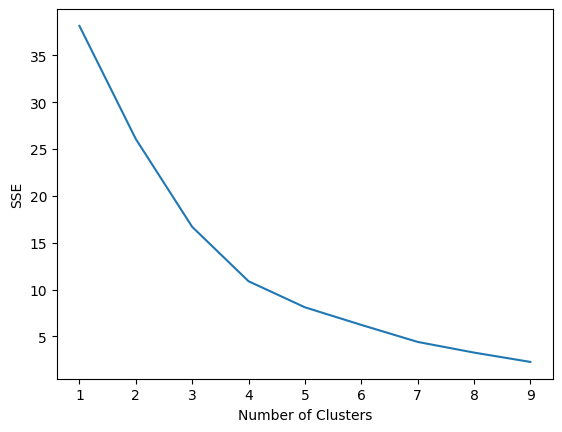

In [1149]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [1150]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [1151]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,17,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_sample)
    SC.append(silhouette_score(df_sample, k_means.labels_))
SC

[0.40000081472309934,
 0.4827670545915395,
 0.5096353688098765,
 0.4853424281394582,
 0.4812248708905561,
 0.3611475116924892,
 0.38598224136772374,
 0.41262452976110464,
 0.39907975794477096,
 0.37672621257216166,
 0.3698651631267717,
 0.3262541733363864,
 0.3447067974785222,
 0.3095396823064154,
 0.30100602350120403]

Text(0, 0.5, 'SC')

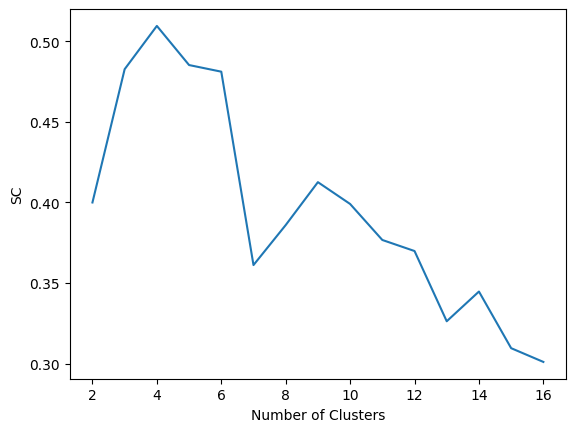

In [1152]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [1153]:
k = 4

# Aplicando o KMeans com k clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
k_means.fit(df_sample)

KMeans(n_clusters=4, n_init=25, random_state=42)

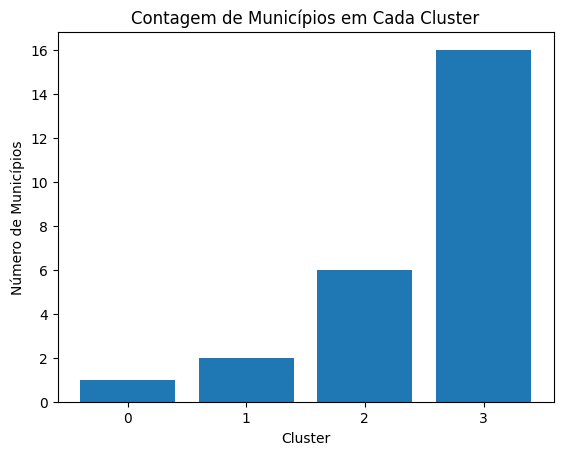

In [1154]:
# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

# Plotar o gráfico de barras
plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

## K-means com PCA

In [1155]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,15,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_pca)
    SSE.append(k_means.inertia_)

SSE

[35.57555584160119,
 23.511056045494417,
 14.152426946112364,
 8.343191490953037,
 5.640737969161476,
 3.849979998640111,
 2.761610246955607,
 1.95409114390367,
 1.4305824793838529,
 1.0340917012531279,
 0.7606782546186452,
 0.5029367300189695,
 0.3183540740056434,
 0.17278580118086959]

Text(0, 0.5, 'SSE')

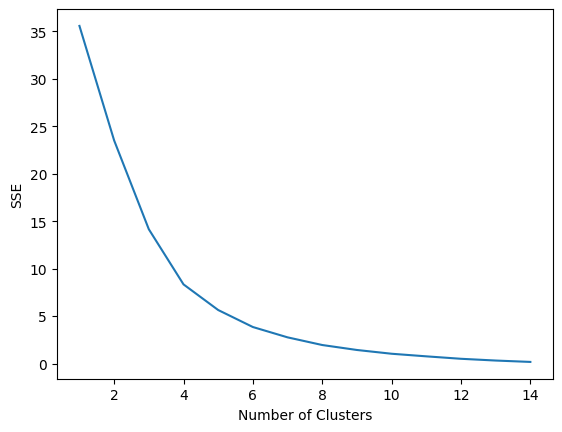

In [1156]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [1157]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,14,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
    k_means.fit(df_pca)
    SC.append(silhouette_score(df_pca, k_means.labels_))
SC

[0.41806110885341746,
 0.5108177574527997,
 0.5405847880932366,
 0.5327565574711678,
 0.42024981148666263,
 0.4746385918027891,
 0.4963846736337929,
 0.46641108307313706,
 0.45437289909514916,
 0.490030453318988,
 0.44552149534695845,
 0.4191976443035264]

Text(0, 0.5, 'SC')

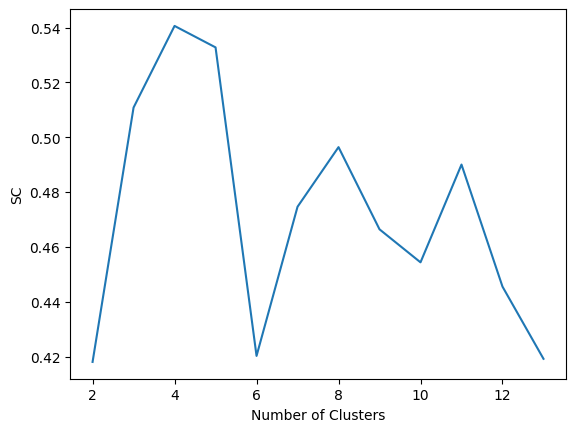

In [1158]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [1159]:
k = 4

# Aplicando o KMeans com n clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
k_means.fit(df_pca)

KMeans(n_clusters=4, n_init=25, random_state=123)

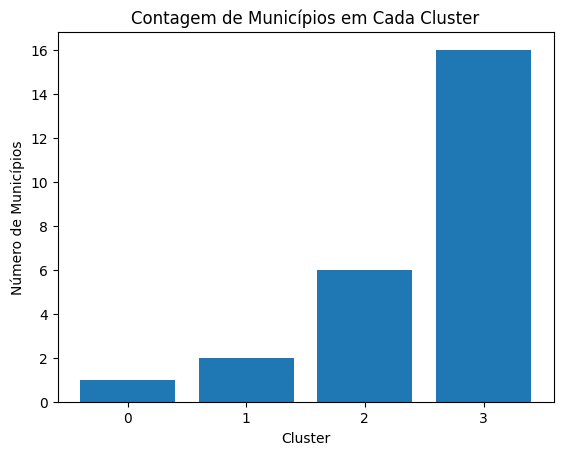

In [1160]:
# Plotar o gráfico de barras para contagem de municípios em cada cluster

# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

In [1161]:
# Salvando os clusters no dataframe
labels = k_means.labels_
df_pca['cluster'] = labels

# Salvando o dataframe em um arquivo csv
df_pca.to_csv('data\\tocsv\\clusterizado.csv', sep=',', index=False)

df_pca.head()

,PC1,PC2,PC3,PC4,cluster
municipios,,,,,
hulha negra,-0.601557,0.075443,-0.145768,-0.006247,0
sao valentim do sul,-0.682314,-0.512254,-0.072228,-0.019699,0
xangri-la,0.044404,-0.434083,-0.035557,0.017995,0
nova padua,-0.710398,-0.512442,-0.073661,-0.017818,0
catuipe,-0.479446,-0.042584,-0.122929,-0.173788,0


In [1162]:
# Criar o gráfico 3D
fig = go.Figure()

# Adicionar os pontos
fig.add_trace(
    go.Scatter3d(
        # Adicionar as dimensões PCA
        x=df_pca['PC1'],
        y=df_pca['PC2'],
        z=df_pca['PC3'],
        mode='markers',
        # Adicionar a cor de acordo com o cluster
        marker=dict(size=5, color=df_pca['cluster'], colorscale='viridis', opacity=0.8),
        # Adicionar o nome dos município ao passar o mouse
        text=df.index
))

# Adicionar o layout
fig.update_layout(
    title=f'Gráfico 3D dos {k} Clusters',
    # Adicionar o nome dos eixos
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Mostrar o gráfico
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/'

## Sistema de Recomendação


In [1163]:
df_recom = df_pca.drop(columns=['cluster'])

df_recom.head()

,PC1,PC2,PC3,PC4
municipios,,,,
hulha negra,-0.601557,0.075443,-0.145768,-0.006247
sao valentim do sul,-0.682314,-0.512254,-0.072228,-0.019699
xangri-la,0.044404,-0.434083,-0.035557,0.017995
nova padua,-0.710398,-0.512442,-0.073661,-0.017818
catuipe,-0.479446,-0.042584,-0.122929,-0.173788


In [1164]:
from sklearn.metrics.pairwise import euclidean_distances

In [1165]:
# Calculando a distância euclidiana entre os componentes principais
dist = euclidean_distances(df_recom)
dist.shape


(25, 25)

In [1166]:
df_recom = df_recom.reset_index()
indices = pd.Series(df_recom.index, index=df_recom['municipios'])
indices

municipios
hulha negra                    0
sao valentim do sul            1
xangri-la                      2
nova padua                     3
catuipe                        4
esmeralda                      5
lajeado do bugre               6
cruz alta                      7
nova ramada                    8
jaguarao                       9
nova petropolis               10
charqueadas                   11
torres                        12
sarandi                       13
fortaleza dos valos           14
almirante tamandare do sul    15
esteio                        16
frederico westphalen          17
canela                        18
piratini                      19
vale verde                    20
restinga seca                 21
santo antonio da patrulha     22
passo do sobrado              23
sao sepe                      24
dtype: int64

In [1167]:
def score_similar(user, indices, dist, num_recommend = 10):

  #obtem os indices dos municípios visitados pelo usuario
  i=indices[user['municipios']]

  # Obtem todas os pares de scores de similaridade de todos os municípios visitados pelo usuario
  # tomando cuidado para remover os municípios ja visitados, pois possuem similaridade igual 1.
  res = pd.DataFrame(dist[i])
  res = res.drop(i, axis='columns').T

  # Cria um score multiplicando as similaridades de cada município visitados com o rating dado pelo usuario.
  score = res.dot(user['rating']).sort_values(ascending=False)

  # Retorna os num_recommend municípios mais próximos
  return indices[score[0:num_recommend].index]

In [1168]:
# Recomendar uma lista de itens para um usuário antigo
usr1 = {
  "municipios": ["canela","xangri-la","cruz alta"],
  "rating": [4.3,2.5,1]
}

# Recomendar uma lista de itens para um usuário novo (sem ratings)
usr2 = {
  "municipios": [],
  "rating": []
}

# Recomendar um item novo para um usuário antigo
usr3 = {
  "municipios": ["canela","xangri-la","cruz alta"],
  "rating": [5,2,1]
}


In [1169]:
score_similar(usr1, indices, dist, 10)

C:\Users\Florensa Dimer\AppData\Local\Temp\ipykernel_14568\1844177721.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



municipios
jaguarao                       9
sao sepe                      24
piratini                      19
passo do sobrado              23
hulha negra                    0
nova padua                     3
vale verde                    20
almirante tamandare do sul    15
lajeado do bugre               6
restinga seca                 21
dtype: int64